In [23]:
import pandas as pd
import sqlite3

In [24]:
# connection à la BDD
conn = sqlite3.connect("database/e-commerce.db")
cur = conn.cursor()

In [48]:
sql_score = """ SELECT c.unique_id, r.score
                FROM order_review r
                JOIN order_dataset o ON o.order_id = r.order_id 
                JOIN customer c ON c.id = o.customer_id                          
                GROUP BY unique_id 
                ORDER BY r.score DESC """

score = cur.execute(sql_score).fetchall()
score

[('ffffd2657e2aad2907e67c3e9daecbeb', 5),
 ('ffff5962728ec6157033ef9805bacc48', 5),
 ('ffff371b4d645b6ecea244b27531430a', 5),
 ('fffcf5a5ff07b0908bd4e2dbc735a684', 5),
 ('fffbf87b7a1a6fa8b03f081c5f51a201', 5),
 ('fffb09418989a0dbff854a28163e47c6', 5),
 ('fffa431dd3fcdefea4b1777d114144f2', 5),
 ('fff5eb4918b2bf4b2da476788d42051c', 5),
 ('fff3e1d7bc75f11dc7670619b2e61840', 5),
 ('fff3a9369e4b7102fab406a334a678c3', 5),
 ('fff2ae16b99c6f3c785f0e052f2a9cfb', 5),
 ('fff22793223fe80c97a8fd02ac5c6295', 5),
 ('fff1afc79f6b5db1e235a4a6c30ceda7', 5),
 ('ffef0ffa736c7b3d9af741611089729b', 5),
 ('ffee94d548cef05b146d825a7648dab4', 5),
 ('ffedff0547d809c90c05c2691c51f9b7', 5),
 ('ffecceca389973ef16660d58696f281e', 5),
 ('ffec10ad4229ba46818560e1c8b40a68', 5),
 ('ffeb904468642a1ce663a322629801cb', 5),
 ('ffe9e41fbd14db4a7361347c56af5447', 5),
 ('ffe9be10b9a58c5464d833e8b1b2c632', 5),
 ('ffe96c782a5bc522bd8bad3bc638981a', 5),
 ('ffe96201d466b0e0dc8139850be29d5d', 5),
 ('ffe780a8995715d9560ca10f3351710

In [49]:

sql_nb_order = """ SELECT c.unique_id, COUNT(o.order_id) AS nb_commande 
                FROM order_dataset o
                JOIN customer c ON c.id = o.customer_id               
                GROUP BY unique_id 
                ORDER BY nb_commande DESC"""

nb_order = cur.execute(sql_nb_order).fetchall()
nb_order

[('8d50f5eadf50201ccdcedfb9e2ac8455', 17),
 ('3e43e6105506432c953e165fb2acf44c', 9),
 ('ca77025e7201e3b30c44b472ff346268', 7),
 ('6469f99c1f9dfae7733b25662e7f1782', 7),
 ('1b6c7548a2a1f9037c1fd3ddfed95f33', 7),
 ('f0e310a6839dce9de1638e0fe5ab282a', 6),
 ('de34b16117594161a6a89c50b289d35a', 6),
 ('dc813062e0fc23409cd255f7f53c7074', 6),
 ('63cfc61cee11cbe306bff5857d00bfe4', 6),
 ('47c1a3033b8b77b3ab6e109eb4d5fdf3', 6),
 ('12f5d6e1cbf93dafd9dcc19095df0b3d', 6),
 ('fe81bb32c243a86b2f86fbf053fe6140', 5),
 ('b4e4f24de1e8725b74e4a1f4975116ed', 5),
 ('74cb1ad7e6d5674325c1f99b5ea30d82', 5),
 ('5e8f38a9a1c023f3db718edcf926a2db', 5),
 ('56c8638e7c058b98aae6d74d2dd6ea23', 5),
 ('4e65032f1f574189fb793bac5a867bbc', 5),
 ('394ac4de8f3acb14253c177f0e15bc58', 5),
 ('35ecdf6858edc6427223b64804cf028e', 5),
 ('f64ec6d8dd29940264cd0bbb5ecade8a', 4),
 ('f34cd7fd85a1f8baff886edf09567be3', 4),
 ('ec7f1811826ab04a27a92197bc40c888', 4),
 ('d3359a56d96666ac0c21bb01e7a61c95', 4),
 ('c8460e4251689ba205045f3ea17884

In [27]:
sql_montant = """ SELECT SUM(p.value) as total, c.unique_id 
                FROM order_paiement p
                JOIN order_dataset o ON o.order_id = p.order_id 
                JOIN customer c ON c.id = o.customer_id                          
                GROUP BY unique_id 
                ORDER BY total DESC
                """
montant = cur.execute(sql_montant).fetchall()
montant

[(13664.08, '0a0a92112bd4c708ca5fde585afaa872'),
 (9553.02, '46450c74a0d8c5ca9395da1daac6c120'),
 (7571.63, 'da122df9eeddfedc1dc1f5349a1a690c'),
 (7274.88, '763c8b1c9c68a0229c42c9fc6f662b93'),
 (6929.31, 'dc4802a71eae9be1dd28f5d788ceb526'),
 (6922.21, '459bef486812aa25204be022145caa62'),
 (6726.66, 'ff4159b92c40ebe40454e3e6a7c35ed6'),
 (6081.54, '4007669dec559734d6f53e029e360987'),
 (4809.44, '5d0a2980b292d049061542014e8960bf'),
 (4764.34, 'eebb5dda148d3893cdaf5b5ca3040ccb'),
 (4681.78, '48e1ac109decbb87765a3eade6854098'),
 (4655.91, 'c8460e4251689ba205045f3ea17884a1'),
 (4513.32, 'edde2314c6c30e864a128ac95d6b2112'),
 (4445.5, 'a229eba70ec1c2abef51f04987deb7a5'),
 (4194.76, 'edf81e1f3070b9dac83ec83dacdbb9bc'),
 (4175.26, 'fa562ef24d41361e476e748681810e1e'),
 (4163.51, 'ca27f3dac28fb1063faddd424c9d95fa'),
 (4053.08, '055ec572ac7f3c7bdd04a183830ebe59'),
 (4042.74, '5e713be0853d8986528d7869a0811d2b'),
 (4034.44, '58483a1c055dfb600f57c5b867174542'),
 (4016.91, '011875f0176909c5cf0b14a9138b

In [47]:
from sklearn.datasets import load_iris
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
import numpy as np

In [58]:
df_montant = pd.DataFrame(montant)
print(df_montant)
df_score = pd.DataFrame(score)
df_nb_order = pd.DataFrame(nb_order)
df_score.columns= ["unique_id_customer",'score']
df_nb_order.columns= ["unique_id_customer",'nb_order']
df_montant.columns = ["total_buy","unique_id_customer"]
df_cluster = pd.merge(df_montant,df_score)
df_cluster = df_cluster.merge(df_nb_order, how = "inner")
df_cluster['nb_order'] = df_cluster['nb_order'].fillna(0)
df_cluster['score'] = df_cluster['score'].fillna(0)
df_cluster = df_cluster[["nb_order","total_buy","score"]]
df_cluster


              0                                 1
0      13664.08  0a0a92112bd4c708ca5fde585afaa872
1       9553.02  46450c74a0d8c5ca9395da1daac6c120
2       7571.63  da122df9eeddfedc1dc1f5349a1a690c
3       7274.88  763c8b1c9c68a0229c42c9fc6f662b93
4       6929.31  dc4802a71eae9be1dd28f5d788ceb526
...         ...                               ...
96090     10.89  b33336f46234b24a613ad9064d13106d
96091     10.07  bd06ce0e06ad77a7f681f1a4960a3cc6
96092      9.59  317cfc692e3f86c45c95697c61c853a6
96093      0.00  968fac81e2c44fb6c1e3ac2a45e6a102
96094      0.00  4fa4365000c7090fcb8cad5713c6d3db

[96095 rows x 2 columns]


,nb_order,total_buy,score
0,1,13664.08,1
1,3,9553.02,1
2,2,7571.63,5
3,1,7274.88,1
4,1,6929.31,5
...,...,...,...
95374,1,10.89,3
95375,1,10.07,5
95376,1,9.59,5
95377,1,0.00,3


In [59]:
scaled_df = StandardScaler().fit_transform(df_cluster)
scaled_df

array([[-0.16270931, 58.62822434, -2.28955803],
       [ 9.14127832, 40.77157865, -2.28955803],
       [ 4.4892845 , 32.16528753,  0.67909709],
       ...,
       [-0.16270931, -0.68090517,  0.67909709],
       [-0.16270931, -0.72255994, -0.80523047],
       [-0.16270931, -0.72255994, -2.28955803]])

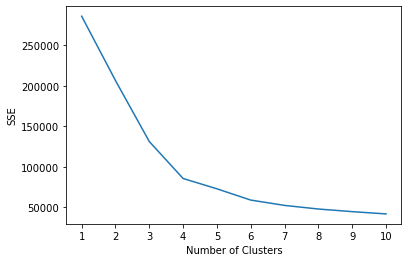

In [60]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [74]:
kmeans = KMeans(init="random", n_clusters=4, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(scaled_df)

#view cluster assignments for each observation
kmeans.labels_

df_cluster['cluster'] = kmeans.labels_

#view updated DataFrame
print(df_cluster)

       nb_order  total_buy  score  cluster
0             1   13664.08      1        3
1             3    9553.02      1        3
2             2    7571.63      5        3
3             1    7274.88      1        3
4             1    6929.31      5        3
...         ...        ...    ...      ...
95374         1      10.89      3        1
95375         1      10.07      5        2
95376         1       9.59      5        2
95377         1       0.00      3        1
95378         1       0.00      1        1

[95379 rows x 4 columns]


In [41]:
df_1cluster = df_cluster[df_cluster["cluster"] == 1]
df_1cluster.mean()

nb_purchase       0.590784
total_buy      1192.652450
cluster           1.000000
dtype: float64

In [115]:
moyenne_buy = df_cluster.groupby(["cluster"])["total_buy"].mean().reset_index()
moyenne_buy


,cluster,total_buy
0,0,289.861588
1,1,147.230842
2,2,132.668529
3,3,1230.179821


In [113]:
moyenne_purchase = df_cluster.groupby(["cluster"])["nb_order"].mean().reset_index()
moyenne_purchase

,cluster,nb_order
0,0,2.11683
1,1,1.00000
2,2,1.00000
3,3,1.01704


In [116]:
moyenne_score = df_cluster.groupby(["cluster"])["score"].mean().reset_index()
moyenne_score

,cluster,score
0,0,4.121910
1,1,1.861220
2,2,4.747494
3,3,3.996413


In [121]:
nb_clients = df_cluster.groupby(["cluster"]).count().reset_index()
nb_count_client = nb_clients[["index","cluster"]]
nb_count_client

,index,cluster
0,2953,0
1,20673,1
2,69523,2
3,2230,3


In [122]:
df_graph = pd.merge(moyenne_score,moyenne_purchase).merge(moyenne_buy).merge(nb_count_client)
#df_graph = pd.merge(df_graph,moyenne_buy)
df_graph

,cluster,score,nb_order,total_buy,index
0,0,4.121910,2.11683,289.861588,2953
1,1,1.861220,1.00000,147.230842,20673
2,2,4.747494,1.00000,132.668529,69523
3,3,3.996413,1.01704,1230.179821,2230


In [93]:
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
source = nb_clients

alt.Chart(source).mark_arc().encode(
    theta=alt.Theta(field="index", type="quantitative"),
    color=alt.Color(field="cluster", type="nominal"),
)

alt.Chart(...)

In [101]:

df_graph = pd.merge(moyenne_score,moyenne_purchase).merge(moyenne_buy).merge(nb_count_client)
source = df_graph

bars = alt.Chart().mark_bar().encode(
    x='cluster:O',
    y=alt.Y('moyenne_score:Q', title='moyenne score'),
    color='moyenne_score:N',
)

error_bars = alt.Chart().mark_errorbar(extent='ci').encode(
    x='year:O',
    y='yield:Q'
)

alt.layer(bars, error_bars, data=source).facet(
    column='site:N'
)

alt.Chart(...)